Importing the Nessicerry Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mkdir -p /root/.kaggle


In [ ]:
#made changes here nothing serious i just uplodedd my kaggle files insted of coping it from drive

#!cp /content/drive/My\ Drive/kaggle.json /root/.kaggle/
!cp kaggle.json /root/.kaggle/


In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation --path "drive/My Drive/Colab Notebooks/UNET_MRI/Dataset"

100% 713M/714M [00:32<00:00, 22.4MB/s]
100% 714M/714M [00:32<00:00, 23.1MB/s]


In [ ]:
#new lib imported

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as k
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#new import
from tensorflow.keras import mixed_precision
# from utils import *


In [ ]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

## Utilities section 


In [ ]:
def plot_from_img_path(rows,columns,list_img_path,list_mask_path):
    fig = plt.figure(figsize=(12,12))
    for i in range(1,rows*columns +1):
        fig.add_subplot(rows,columns,i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask,alpha=0.4)
    plt.show()

""" After mask adjustment, if the value is <=0.5 then that mask
    will be considered a complete black one and does not have any tumor """
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)


def trainGenerator(
    data_frame,batch_size,
    aug_dict,image_color_mode="rgb",
    mask_color_mode="grayscale",image_save_prefix="image",
    mask_save_prefix="mask",flag_multi_class=False,
    num_class=2,save_to_dir=None,
    target_size=(256,256),seed=1):
  

  """
    Can generate image and mask at the same time.
    Use the same seed for image_datagen and mask_datagen 
    to ensure the transformation for image and mask is the same.
    If you want to visualize the results of generator, set save_to_dir = "your path"

  """
  image_datagen= ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  image_generator = image_datagen.flow_from_dataframe(
      data_frame,x_col="image_filenames_train",
      class_mode=None,color_mode=image_color_mode,
      target_size=target_size,batch_size=batch_size,
      save_to_dir=save_to_dir,save_prefix=image_save_prefix,
      seed=seed
  )

  mask_generator= mask_datagen.flow_from_dataframe(
      data_frame,x_col="mask",
      class_mode=None,color_mode=mask_color_mode,
      target_size=target_size,batch_size=batch_size,
      save_to_dir=save_to_dir,save_prefix=mask_save_prefix,
      seed=seed
  )
  train_generator=zip(image_generator,mask_generator)
  for (img,mask) in train_generator:
    imag,mask = adjustData(img,mask,flag_multi_class,num_class)
    yield(img,mask)
##

def dice_coefficients(y_true,y_pred,smooth=100):
 
  y_true_flatten = k.cast(k.flatten(y_true), 'float32')
  y_pred_flatten = k.cast(k.flatten(y_pred), 'float32')


  intersection = k.sum(y_true_flatten*y_pred_flatten)
  union = k.sum(y_true_flatten) + k.sum(y_pred_flatten)
  return (2* intersection + smooth) / (union + smooth)


def dice_coefficients_loss(y_true,y_pred,smooth=100):
  return 1-dice_coefficients(y_true,y_pred)

def iou(y_true,y_pred,smooth=100):
  ## we put multibly cuz we need to get one only if the mask and the prediction have 1 for each pixel
  intersection = k.sum(y_true * y_pred)
  sum = k.sum(y_true + y_pred)
  iou = (intersection+smooth)/(sum - intersection + smooth)
  return iou

def jaccard_distance(y_true,y_pred):
  y_true_flatten = k.flatten(y_true)
  y_pred_flatten = k.flatten(y_pred)
  return -iou(y_true_flatten,y_pred_flatten)


In [ ]:
# Downloading dataset from kaggle and store it in the drive
Main_folder_path =  os.path.join(os.getcwd(),"drive/MyDrive/Colab Notebooks/UNET_MRI/")
Dataset_path = os.path.join(Main_folder_path,"Dataset")
#os.chdir(Main_folder_path)
#os.getcwd()
#os.mkdir("Dataset")
# os.listdir(os.getcwd(Dataset_path))

In [ ]:
# Setting size parameters of images
im_width,im_hieght = 256,256

Loading the image and masks path

In [ ]:
#made some changes here !unzip is alot faster and easier to read plus made it extract the data to colab env no big deal
image_filenames_train = []

# Extracting the folder first
#import zipfile
#with zipfile.ZipFile(os.path.join(Dataset_path,"lgg-mri-segmentation.zip"),'r') as zz:
  #zz.extractall(os.path.join(Dataset_path,"lgg-mri-segmentation"))
Dataset_path="lgg-mri-segmentation"
!unzip -q 'drive/My Drive/Colab Notebooks/UNET_MRI/Dataset/lgg-mri-segmentation.zip' -d 'lgg-mri-segmentation'

In [ ]:
#  Creating a list of all files containing the word 'mask'
mask_files = glob(os.path.join(Dataset_path,"lgg-mri-segmentation","kaggle_3m","*","*_mask*"))
mask_files[:2]

['lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_37_mask.tif',
 'lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_13_mask.tif']

In [ ]:
# Getting the non-mask images from mask files list by removing the mask word

for i in mask_files:
  image_filenames_train.append(i.replace('_mask',''))

image_filenames_train[:2]

['lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_37.tif',
 'lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_13.tif']

Plotting few images and masks

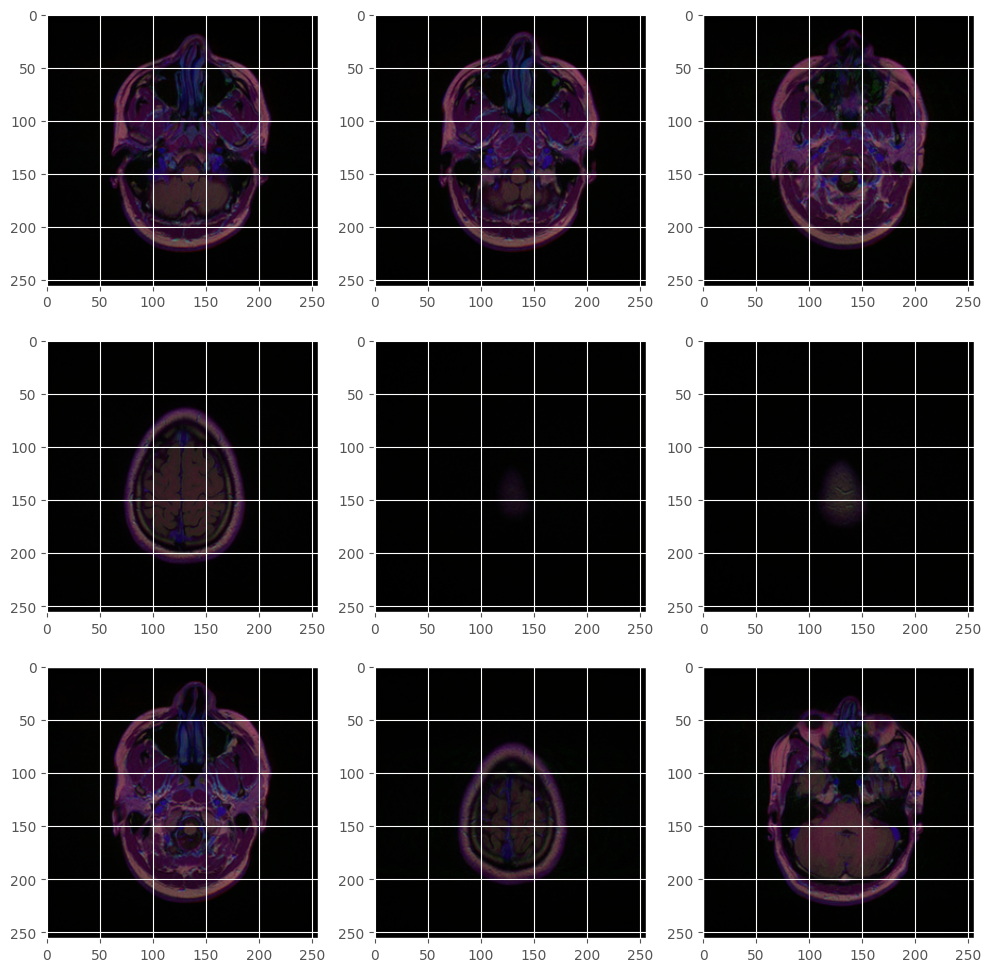

In [ ]:
plot_from_img_path(3,3,image_filenames_train,mask_files)

Create dataframe and split data on train set, validation set and test set 

In [ ]:
df = pd.DataFrame(data={'image_filenames_train':image_filenames_train,'mask':mask_files})
df.head()

,image_filenames_train,mask
0,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
1,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
2,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
3,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
4,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...


In [ ]:
df_train, df_test = train_test_split(df,test_size=0.1,)
#Further split train set to train set and validation set
df_train, df_val = train_test_split(df_train,test_size=0.2)
print(f' Size of train dataframe: {df_train.shape}')
print(f' Size of test dataframe{df_test.shape}')
print(f'Size of validation dataframe{df_val.shape}')

 Size of train dataframe: (2828, 2)
 Size of test dataframe(393, 2)
Size of validation dataframe(708, 2)


UNET Architecture

In [ ]:
#made some changes, removed some duplicated layers, add n_f parameter it will much easier now to
#control the network size 
def unet(input_size=(256,256,3),n_f=64):
  inputs = Input(input_size)

  # Encoding leg:
  conv1 = Conv2D(filters=n_f,kernel_size=(3,3),padding='same')(inputs)
  bn1 = Activation("relu")(conv1)
  conv1 = Conv2D(filters=n_f,kernel_size=(3,3),padding="same")(bn1)
  bn1 = Activation("relu")(conv1)
  #bn1 = Activation("relu")(bn1)
  pool1 = MaxPooling2D(pool_size=(2,2))(bn1)

  conv2 = Conv2D(filters=n_f*2,kernel_size=(3,3),padding='same')(pool1)
  bn2 = Activation("relu")(conv2)
  conv2 = Conv2D(filters=n_f*2,kernel_size=(3,3),padding="same")(bn2)
  bn2 = Activation("relu")(conv2)
  #bn2 = Activation("relu")(bn2)
  pool2 = MaxPooling2D(pool_size=(2,2))(bn2)


  conv3 = Conv2D(filters=n_f*4,kernel_size=(3,3),padding='same')(pool2)
  bn3 = Activation("relu")(conv3)
  conv3 = Conv2D(filters=n_f*4,kernel_size=(3,3),padding="same")(bn3)
  bn3 = Activation("relu")(conv3)
  #bn3 = Activation("relu")(bn3)
  pool3 = MaxPooling2D(pool_size=(2,2))(bn3)


  conv4 = Conv2D(filters=n_f*8,kernel_size=(3,3),padding='same')(pool3)
  bn4 = Activation("relu")(conv4)
  conv4 = Conv2D(filters=n_f*8,kernel_size=(3,3),padding="same")(bn4)
  bn4 = Activation("relu")(conv4)
  #bn4 = Activation("relu")(bn4)
  pool4 = MaxPooling2D(pool_size=(2,2))(bn4)

  conv5 = Conv2D(filters=n_f*16,kernel_size=(3,3),padding=("same"))(pool4)
  bn5 = Activation("relu")(conv5)
  conv5 = Conv2D(filters=n_f*16,kernel_size=(3,3),padding=('same'))(bn5)
  bn5 = BatchNormalization(axis=3)(conv5)
  bn5 = Activation("relu")(bn5)


  """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
  The gray arrows (in the unet image) indicate the skip connections that concatenate
  the encoder feature map with the decoder, which helps the backward flow of 
  gradients for improved training.
   """
  # Decoding leg
  conv6 = concatenate([Conv2DTranspose(n_f*8,kernel_size=(2,2),strides=(2,2),padding='same')(bn5) , conv4 ],axis=3)
  bn6 = Activation('relu')(conv6)
  conv6 = Conv2D(filters=n_f*8,kernel_size=(3,3),padding='same')(bn6)
  bn6 = BatchNormalization(axis=3)(conv6)
  bn6 = Activation('relu')(bn6)

  up7 = concatenate([Conv2DTranspose(n_f*4,kernel_size=(2,2),strides=(2,2),padding='same')(bn6) , conv3 ],axis=3)
  conv7 = Conv2D(filters=n_f*4,kernel_size=(3,3),padding='same')(up7)
  bn7 = Activation('relu')(conv7)
  conv7 = Conv2D(filters=n_f*4,kernel_size=(3,3),padding='same')(bn7)
  bn7 = BatchNormalization(axis=3)(conv7)
  bn7 = Activation('relu')(bn7)  

  up8 = concatenate([Conv2DTranspose(n_f*2,kernel_size=(2,2),strides=(2,2),padding='same')(bn7) , conv2 ],axis=3)
  conv8 = Conv2D(filters=n_f*2,kernel_size=(3,3),padding='same')(up8)
  bn8 = Activation('relu')(conv8)
  conv8 = Conv2D(filters=n_f*2,kernel_size=(3,3),padding='same')(bn8)
  bn8 = BatchNormalization(axis=3)(conv8)
  bn8 = Activation('relu')(bn8)

  up9 = concatenate([Conv2DTranspose(n_f,kernel_size=(2,2),strides=(2,2),padding='same')(bn8) , conv1 ],axis=3)
  conv9 = Conv2D(filters=n_f,kernel_size=(3,3),padding='same')(up9)
  bn9 = Activation('relu')(conv9)
  conv9 = Conv2D(filters=n_f,kernel_size=(3,3),padding='same')(bn9)
  bn9 = BatchNormalization(axis=3)(conv9)
  bn9 = Activation('relu')(bn9)

  conv10 = Conv2D(filters=1,kernel_size=(1,1),activation='sigmoid')(bn9)

  return Model(inputs=[inputs],outputs=[conv10])




In [ ]:
#add summary function to have a little look on the network

model = unet(input_size=(im_hieght,im_width,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

Training Phase

In [ ]:
#I would advice to comment the augmentation operation and train without them, as they could hold the
#the training in small experince they add 20s to each epoch with little to add 
#add callbacks
#i didn't add random name to the models so you could implent ypur own method you could just use model_name=input("enter the name of the model")
#I would expermient with higher batch sizes
EPOCHS = 100
BATCH_SIZE = 32
learning_rate=1e-4
smooth = 100


train_generator_param = dict(
    rotation_range=0.2,
                           width_shift_range=0.05,
                             height_shift_range=0.05,
                            shear_range=0.05,
                             zoom_range=0.05,
                             horizontal_flip=True,
                            fill_mode='nearest'
                          )
train_gen = trainGenerator(df_train,BATCH_SIZE,train_generator_param,
                           target_size=(im_hieght,im_width))

test_gen = trainGenerator(df_test,BATCH_SIZE,dict(),target_size=(im_hieght,im_width))

model = unet(input_size=(im_hieght,im_width,3))

decay_rate = learning_rate/EPOCHS

optimizer = Adam(lr=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=None,decay=decay_rate,amsgrad=False)

model.compile(optimizer=optimizer,loss=dice_coefficients_loss,metrics=['binary_accuracy',iou,dice_coefficients])

callbacks = [ModelCheckpoint('drive/MyDrive/unet_lgg.hdf5',verbose=1,
                             monitor='val_iou',
                             
                             mode='max',save_best_only=True),
             tf.keras.callbacks.CSVLogger('drive/MyDrive/training.csv'),
             tf.keras.callbacks.TensorBoard(log_dir="drive/MyDrive/logs")

]
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train)/BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data = test_gen,
                    validation_steps=len(df_test)/BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
89/88 [==============================] - ETA: 0s - loss: 0.9468 - binary_accuracy: 0.7120 - iou: 0.0277 - dice_coefficients: 0.0536Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_iou improved from -inf to 0.02931, saving model to drive/MyDrive/unet_lgg.hdf5
88/88 [==============================] - 83s 901ms/step - loss: 0.9468 - binary_accuracy: 0.7120 - iou: 0.0277 - dice_coefficients: 0.0536 - val_loss: 0.9444 - val_binary_accuracy: 0.8948 - val_iou: 0.0293 - val_dice_coefficients: 0.0566
Epoch 2/100
89/88 [==============================] - ETA: 0s - loss: 0.9010 - binary_accuracy: 0.9392 - iou: 0.0522 - dice_coefficients: 0.0984
Epoch 2: val_iou improved from 0.02931 to 0.03491, saving model to drive/MyDrive/unet_lgg.hdf5
88/88 [==============================] - 79s 893ms/step - loss: 0.9010 - binary_accuracy: 0.9392 - iou: 0.0522 - dice_coefficients: 0.0984 - val_loss: 0.9337 - val_binary_accuracy: 0.8285 - val_iou: 0.0349 - val_d

In [ ]:
#fixed some typoes

history_post_training = history.history
train_dice_coeff = history_post_training['dice_coefficients']
test_dice_coeff = history_post_training['val_dice_coefficients']

train_jaccard_index = history_post_training['iou']
test_jaccard_inex = history_post_training['val_iou']

train_loss = history_post_training['loss']
test_loss = history_post_training['val_loss']

Plotting metrics for the trained Unet

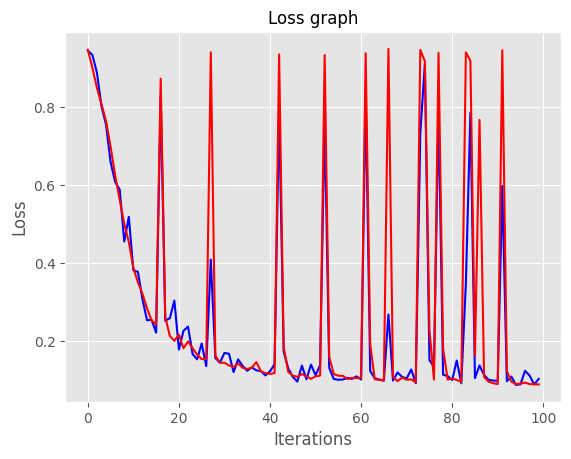

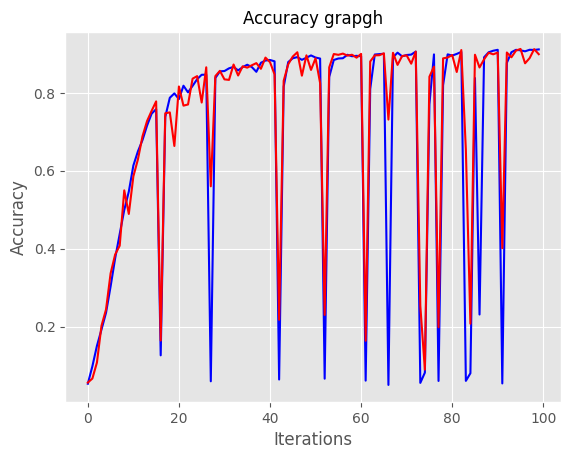

In [ ]:
#very intersting behvior the model is very unstable
#another thing to notice is the model loss pleuted and barely improved after epoch 60ish
#to do list:
#1- add legends to the plots
plt.figure(1)
plt.plot(test_loss,'b-')
plt.plot(train_loss,'r-')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss graph',fontsize=12)


plt.figure(2)
plt.plot(train_dice_coeff,'b-')
plt.plot(test_dice_coeff,'r-')

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy grapgh',fontsize=12)

plt.show()


Loading the trained and saved model

In [ ]:
#the below line gives an error didn't have time to fix it colab ended the session prob a typo in dice_coefficient_loss 
#model = load_model('drive/MyDrive/unet.hdf5',custom_objects={'dice_coefficient_loss':dice_coefficients_loss,
 #                                              'iou':iou,'dice_coefficient':dice_coefficients})
#added df_test[382:384] to test only one image and to use latter   
test_gen = trainGenerator(df_test[382:384],BATCH_SIZE,dict(),target_size=(im_hieght,im_width))
results = model.evaluate(test_gen,steps=2)

print('Test Loss',results[0])
print('Test IoU',results[2])
print('Test Dice Loss',results[3])

Found 2 validated image filenames.
Found 2 validated image filenames.
2/2 [==============================] - 0s 36ms/step - loss: 0.1109 - binary_accuracy: 0.9970 - iou: 0.8054 - dice_coefficients: 0.8891
Test Loss 0.11085695028305054
Test IoU 0.8054109215736389
Test Dice Loss 0.8891430497169495


Plotting Predicted Masks Segmentation results from the test image set

2/2 [==============================] - 0s 46ms/step
(4, 256, 256, 1)
383
172582
(256, 256)


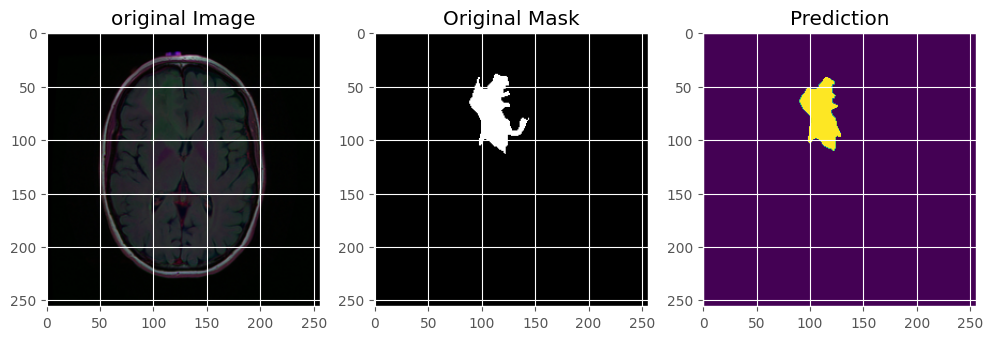

In [ ]:
#some fuckery magic going in here if you input an "img" the prediction is wrong (whole zero numpy), but if you 
#pick an image from the test data "test_gen" it works fine
#this mean there is a missing step in addition to img/255 img[np.newaxis,:,:,:] 
#changed range to 1 becuase i was running out of time
#to do list :
#-add continue leanring ability
for i in range(1):
  index = np.random.randint(1,len(df_test.index))
  index=383
  img = cv2.imread(df_test['image_filenames_train'].iloc[index])
  img = cv2.resize(img,(im_hieght,im_width))
  img = img/255
  img = img[np.newaxis,:,:,:]
  #changed img to test_gen whre in the previous cell i picked only one image
  predicted_img = model.predict(test_gen,steps=2)

  plt.figure(figsize=(12,12))
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(img))
  plt.title("original Image")
 # predicted_img=np.squeeze(predicted_img)
  print(predicted_img.shape)
  print(index)

  print(np.count_nonzero(predicted_img == 0))
  print(ressultss.shape)
  #print(predicted_img)

  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
  plt.title('Original Mask')

  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(predicted_img[0,:,:,:]) > .5)
  plt.title('Prediction')

  plt.show()

In [ ]:
df_test

,image_filenames_train,mask
1499,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
677,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
744,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
3145,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
3176,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
...,...,...
3466,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
2978,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
3764,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
1073,lgg-mri-segmentation/lgg-mri-segmentation/kagg...,lgg-mri-segmentation/lgg-mri-segmentation/kagg...
